In [ ]:
!wget https://www.dropbox.com/s/w3zlhing4dkgeyb/train.zip?dl=0

!unzip train.zip?dl=0

--2023-11-29 21:29:15--  https://www.dropbox.com/s/w3zlhing4dkgeyb/train.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/w3zlhing4dkgeyb/train.zip [following]
--2023-11-29 21:29:15--  https://www.dropbox.com/s/raw/w3zlhing4dkgeyb/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0358d92456a44335fc3792fb80.dl.dropboxusercontent.com/cd/0/inline/CIcUaxluT7CYqbXycD93Aeg6zk3tMSxS9DbG5MbBN578ZF4pvgzhElxF73PZMGyxVpbbkOda2DgUwppj-S_Vu7FY1pIkrgP-9oW4JkXiu4CDaP-M9zAv0HbjYJCTqGzEHrJfZWSLkUFjikcQ9XB-3gtw/file# [following]
--2023-11-29 21:29:16--  https://uc0358d92456a44335fc3792fb80.dl.dropboxusercontent.com/cd/0/inline/CIcUaxluT7CYqbXycD93Aeg6zk3tMSxS9DbG5MbBN578ZF4pvgzhElxF73PZMGyxVpbbkOda2DgUwppj-S_Vu7FY1pIkrgP-9oW4JkXiu4

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Model
from keras.layers import Flatten, Dense

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
base_model = MobileNet( input_shape=(224, 224, 3), include_top= False)

for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(units=9, activation='softmax')(x)

model = Model(base_model.input, x)


17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [ ]:
model.compile(optimizer='adam', loss= "categorical_crossentropy", metrics=['accuracy'])

Prep data using data generator

In [ ]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip=True,
    rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/train",
                                               target_size=(244,244),
                                               batch_size=32,
                                               )
train_data.class_indices

Found 350 images belonging to 7 classes.


{'Angry': 0,
 'Disguist': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1/255)

val_data = val_datagen.flow_from_directory(directory= "/content/train",
                                           target_size=(244,244),
                                           batch_size=32,
                                          )

Found 350 images belonging to 7 classes.


Visualizing data that is fed to train data generator

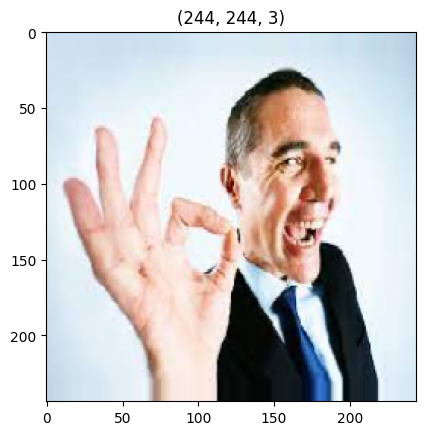

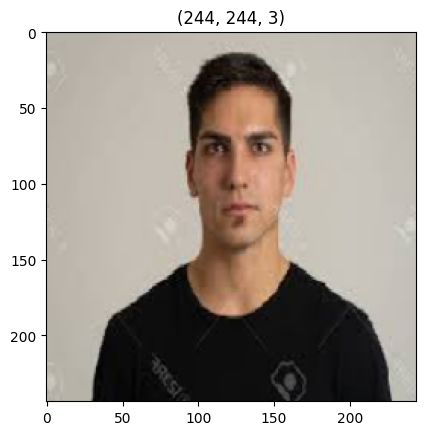

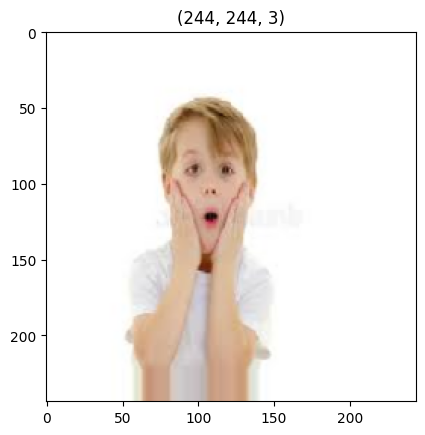

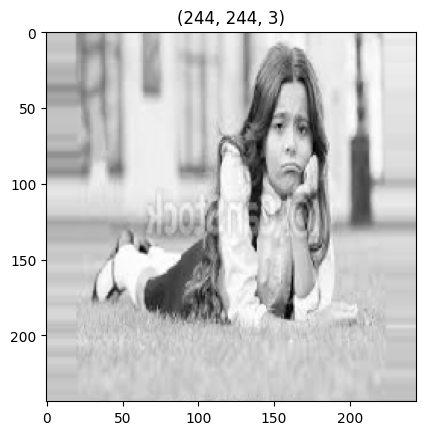

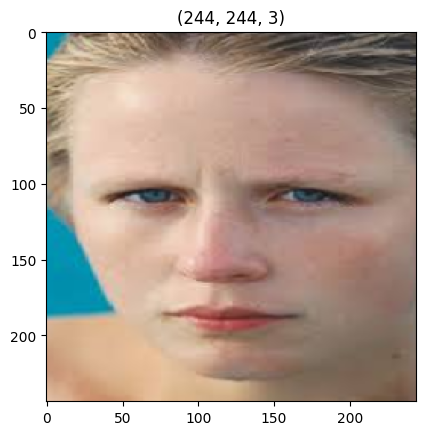

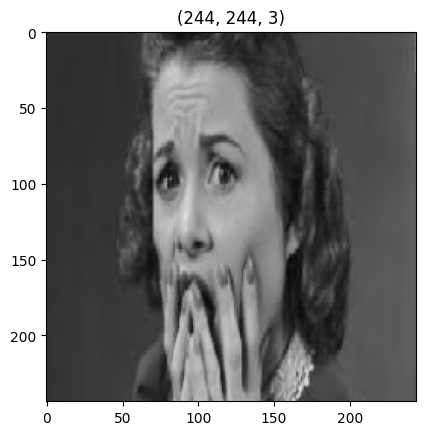

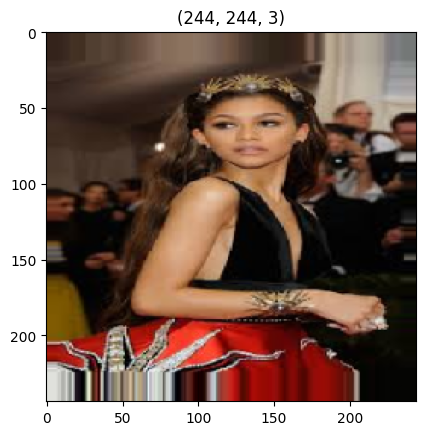

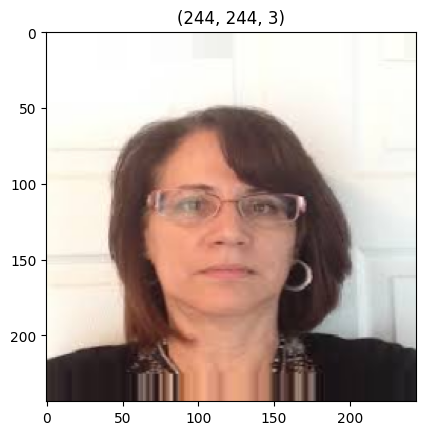

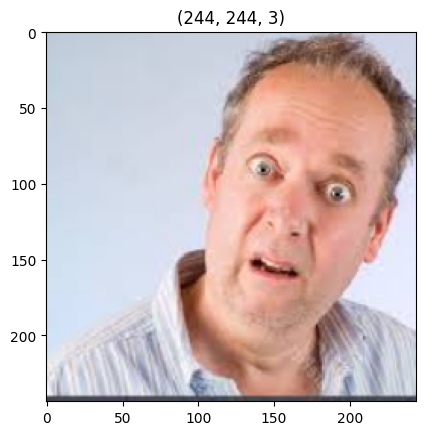

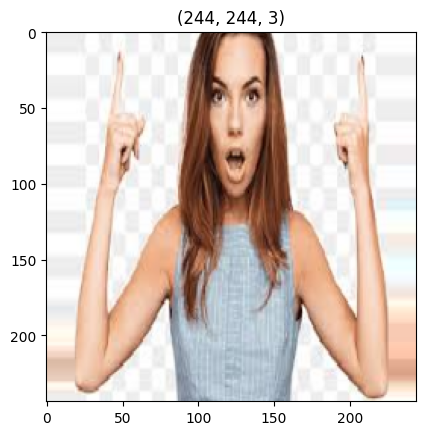

In [ ]:
t_img, label = train_data.next()

def plotImages(img_arr, label):
  """
  input  :- images array
  output :- plots the images
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()

    count += 1
    if count == 10:
      break

plotImages(t_img, label)

## having early stopping and model checkpoint


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, verbose=1, mode='auto')

mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose=1, save_best_only= True, mode='auto')

call_back = [es, mc]

In [ ]:
hist = model.fit_generator(train_data,
                           steps_per_epoch=10,
                           epochs=30,
                           validation_data= val_data,
                           validation_steps= 8,
                           callbacks=[es,mc])

<ipython-input-12-d55059a41d40>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_data,


Epoch 1/30


InvalidArgumentError: ignored

In [ ]:
from keras.models import load_model
model = load_model("/content/best_model.h5")

In [ ]:
h = hist.history
h.keys()

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.title("acc vs v-acc")
plt.show()

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")
plt.title("loss vs v-loss")
plt.show()

In [ ]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

In [ ]:
path = "/content/download.jpg"
img = load_img(path, target_size=(244, 244))

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

plt.imshow(input_arr[0])
plt.title("input image")
plt.show()